#### Import Libaries

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
import keras as k
import os
import cv2
import pickle
from keras.utils import to_categorical
from PIL import Image
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

#### Loading and Preprocessing Data

In [150]:
# Directory containing the images
directory = '/content/drive/MyDrive/CAPTCHA/samples'

In [151]:
sample = []

for filename in os.listdir(directory):
    image_path = os.path.join(directory, filename)
    img = Image.open(image_path)
    sample.append((filename, img))

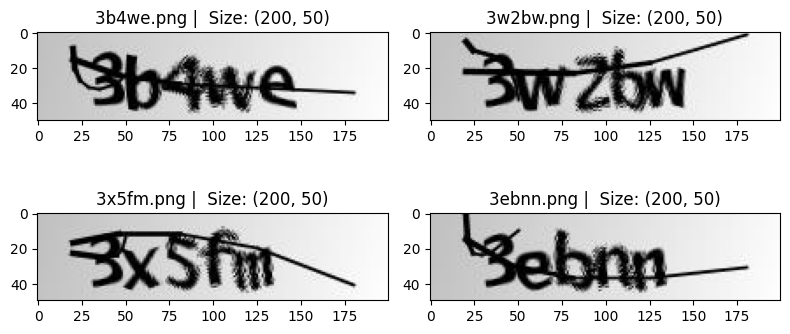

In [152]:
sample_images = sample[:4]

fig, axes = plt.subplots(2, 2, figsize=(8, 4))

for i in range(len(sample_images)):
    row = i // 2
    col = i % 2
    filename, img = sample_images[i]
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'{filename} |  Size: {img.size}')
    axes[row, col].axis()

plt.tight_layout()
plt.show()

In [153]:
unique_characters = set()
max_length = 0
total_samples = 0

for filename in os.listdir(directory):
    # Extract characters from the filename
    characters = os.path.splitext(filename)[0]
    # Update unique characters
    unique_characters.update(set(characters))
    # Update maximum length
    max_length = max(max_length, len(characters))
    # Update total samples
    total_samples += 1

characters_present = sorted(list(unique_characters))

print("Number of unique characters in the whole dataset:", len(unique_characters))
print("Maximum length of any captcha:", max_length)
print("Characters present:", characters_present)
print("Total number of samples in the dataset:", total_samples)


Number of unique characters in the whole dataset: 19
Maximum length of any captcha: 5
Characters present: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Total number of samples in the dataset: 1070


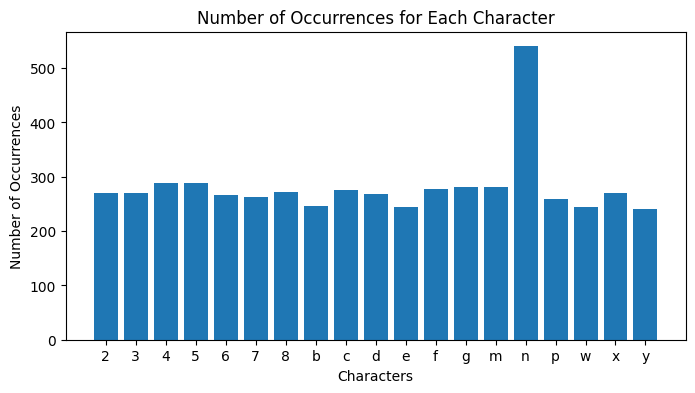

In [154]:
character_counts = {}

for filename in os.listdir(directory):
    # Extract characters from the filename
    characters = os.path.splitext(filename)[0]
    # Update character counts
    for char in characters:
        character_counts[char] = character_counts.get(char, 0) + 1

characters_present = sorted(character_counts.keys())
counts = [character_counts[char] for char in characters_present]

plt.figure(figsize=(8, 4))
plt.bar(characters_present, counts)
plt.xlabel('Characters')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences for Each Character')
plt.show()

#### Preprocessing Data

In [155]:
def load_data(data_dir):
    images = []
    labels = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        label = os.path.splitext(img_name)[0]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
        kernel_close = np.ones((5, 5), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close)
        kernel_dilate = np.ones((2, 2), np.uint8)
        image = cv2.dilate(image, kernel_dilate, iterations=1)
        image = cv2.GaussianBlur(image, (5, 5), 0)

        # Split the image into segments
        segments = [image[10:50, 30:50], image[10:50, 50:70],
                    image[10:50, 70:90], image[10:50, 90:110], image[10:50, 110:130]]

        for segment, letter in zip(segments, label):
          images.append(segment)
          labels.append(letter)

    return np.array(images), np.array(labels)

In [156]:
images, labels = load_data(directory)

In [157]:
images=images.astype('float32')
images/=255

In [158]:
labels_le = LabelEncoder().fit_transform(labels)
labels_ohe = OneHotEncoder(sparse = False).fit_transform(labels_le.reshape(len(labels_le),1))

In [159]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_ohe, test_size = 0.2, random_state = 42)

In [160]:
row, col = images.shape[1],images.shape[2]
categories = labels_ohe.shape[1]
info = {labels_le[i] : labels[i] for i in range(len(labels))}

#### Training the Model

In [161]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=(row, col, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1500))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 40, 20, 16)        160       
                                                                 
 activation_18 (Activation)  (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 20, 10, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 20, 10, 16)        2320      
                                                                 
 activation_19 (Activation)  (None, 20, 10, 16)        0         
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 10, 5, 16)         0         
 ng2D)                                                

In [163]:
batch_size = 150
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    shuffle=True)

Epoch 1/200
29/29 [==============================] - 6s 150ms/step - loss: 2.9157 - accuracy: 0.1009 - val_loss: 2.8505 - val_accuracy: 0.0935
Epoch 2/200
29/29 [==============================] - 2s 83ms/step - loss: 2.4981 - accuracy: 0.2243 - val_loss: 1.9184 - val_accuracy: 0.4477
Epoch 3/200
29/29 [==============================] - 2s 77ms/step - loss: 1.7756 - accuracy: 0.4769 - val_loss: 1.3503 - val_accuracy: 0.6308
Epoch 4/200
29/29 [==============================] - 2s 81ms/step - loss: 1.4178 - accuracy: 0.5871 - val_loss: 1.1295 - val_accuracy: 0.6710
Epoch 5/200
29/29 [==============================] - 2s 82ms/step - loss: 1.2439 - accuracy: 0.6357 - val_loss: 0.9850 - val_accuracy: 0.7168
Epoch 6/200
29/29 [==============================] - 4s 131ms/step - loss: 1.1345 - accuracy: 0.6804 - val_loss: 0.8832 - val_accuracy: 0.7514
Epoch 7/200
29/29 [==============================] - 3s 110ms/step - loss: 1.0300 - accuracy: 0.7072 - val_loss: 0.8165 - val_accuracy: 0.7523
Epo

#### Evaluating the Model performance

In [164]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

34/34 [==============================] - 0s 7ms/step - loss: 0.7013 - accuracy: 0.8832
Test loss: 0.701292872428894
Test accuracy: 0.8831775784492493


#### Plot for training and validation accuracy

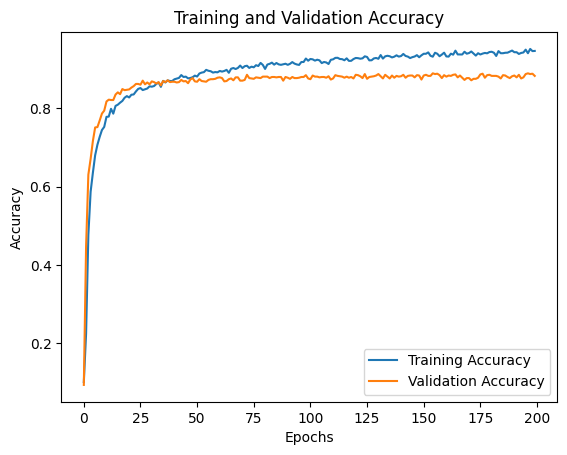

In [165]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Plot for training and validation loss

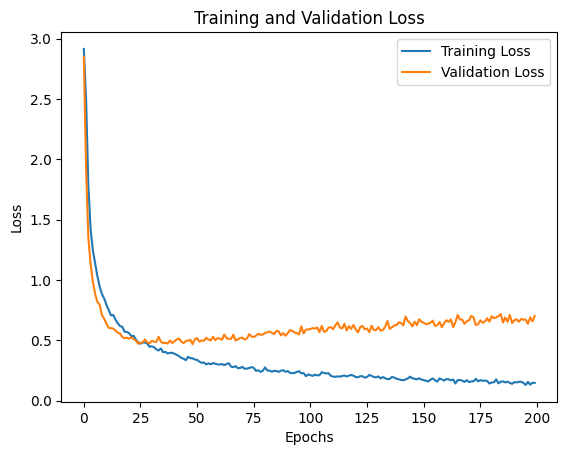

In [166]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Predicting with new image

In [167]:
def predict_captcha(img_path) :

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

    image = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0)
    kernel = np.ones((5,5),np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image, kernel, iterations = 1)
    image = cv2.GaussianBlur(image, (5,5), 0)


    x = [image[10:50, 30:50], image[10:50, 50:70], image[10:50, 70:90],
                  image[10:50, 90:110], image[10:50, 110:130]]

    X_pred = []
    for i in range(5) :
        X_pred.append(img_to_array(Image.fromarray(x[i])))

    X_pred = np.array(X_pred)
    X_pred/= 255.0

    y_pred = model.predict(X_pred)
    y_pred = np.argmax(y_pred, axis = 1)

    print('Prediction: ', end='')
    for res in y_pred :
        print(info[res], end='')

    print('\nActual:    ', img_path[len(img_path)-9:len(img_path)-4])

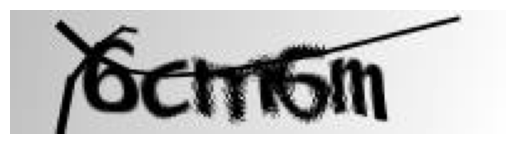

1/1 [==============================] - 0s 156ms/step
Prediction: 6cn6m
Actual:     6cm6m


In [168]:
predict_captcha('/content/drive/MyDrive/CAPTCHA/samples/6cm6m.png')

#### Save the model

In [169]:
model.save('cnn_model.h5')

with open('cnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully!")

Model saved successfully!
